In [82]:
import pandas as pd
import pingouin as pg
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

plt.rcParams['font.family'] = 'Malgun Gothic'     # 한글 폰트 설정 (윈도우용)
plt.rcParams['axes.unicode_minus'] = False  


csv_path = 'superhost.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)

In [83]:
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_location_boolean,log_price,room_new_type,transport_count,infrastructure_count,tourism_count,poi_pca1,parsed_amenities,common_amenity_score,type_amenity_score
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,1,5.303305,mid,7,78,1,-42.210005,"['Refrigerator', 'Dishes and silverware', 'Wif...",0.2,0.333
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,1,4.418841,upper-mid,3,79,4,-41.258968,"['Oven', 'Blender', 'Luggage dropoff allowed',...",0.6,0.833
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,1,6.641182,low-mid,11,109,2,-11.072911,"['Portable fans', 'Oven', 'Baking sheet', 'Fir...",0.8,0.625
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,1,4.941642,low-mid,4,34,2,-86.236573,"['Fire extinguisher', 'Clothing storage: close...",1.0,0.625
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,1,4.875197,mid,7,117,1,-3.252311,"['Oven', 'Rice maker', 'Laundromat nearby', 'L...",0.6,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,1,4.290459,mid,4,58,4,-62.201185,"['Air conditioning', 'Carbon monoxide alarm', ...",0.6,0.333
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,1,4.077537,mid,4,27,1,-93.259690,"['Air conditioning', 'Carbon monoxide alarm', ...",0.6,0.333
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,1,5.703782,mid,8,276,6,155.763769,"['Air conditioning', 'Carbon monoxide alarm', ...",0.6,0.333


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 1. 목표 변수 설정
TARGET = 'host_is_superhost'
y = df[TARGET].astype(int)

# === 변수 목록 정의 ===

strategy_cols = ['amenities_cnt', 'availability_365', 'price', 'host_about_length_group', 'room_type','name_length_group', 'description_length_group',
                 'host_has_profile_pic', 'host_response_time_score','type_amenity_score','common_amenity_score',
                 'host_acceptance_rate_score', 'host_identity_verified','is_long_term', 'accommodates']

# === 데이터셋 준비 ===
X = df[strategy_cols]
y = df['host_is_superhost'].astype(int)

# 원핫 인코딩
X_encoded = pd.get_dummies(X, drop_first=False)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# === 랜덤포레스트 모델 정의 ===
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced')

# 모델 학습
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# === 평가 지표 출력 ===
print("\n=== 랜덤포레스트 전략모델 성능 평가 ===")
print(classification_report(y_test, y_pred))
print("AUC:", round(roc_auc_score(y_test, y_proba), 4))

# === 변수 중요도 출력 ===
importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
print("\n=== 변수 중요도 ===")
print(importances.sort_values(ascending=False).round(3))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. 변수 리스트 정의 (신뢰 변수는 별도 처리)
strategy_cols = [
    'amenities_cnt', 'availability_365', 'price',
    'instant_bookable', 'host_about_length_group', 'room_type',
    'neighbourhood_group_cleansed', 'name_length_group', 'description_length_group',
    'is_long_term', 'accommodates'
]

trust_cols = ['host_has_profile_pic', 'host_response_time_score', 'host_acceptance_rate_score', 'host_identity_verified']

# 2. 모델링용 데이터 복사
df_model = df.copy()

# 3. 신뢰 변수들 결측치는 0으로 채우고 host_trust_score 생성 (평균)
df_model[trust_cols] = df_model[trust_cols].fillna(0)
df_model['host_trust_score'] = df_model[trust_cols].mean(axis=1)

# 4. 모델링에 사용할 변수 리스트에 host_trust_score 추가
model_cols = strategy_cols + ['host_trust_score']

# 5. 설명 변수 준비 (원래 신뢰 변수는 제외)
X_raw = df_model[model_cols].copy()

# 6. 리스트형 변수 있으면 제거 (예외 처리)
for col in X_raw.columns:
    if X_raw[col].apply(lambda x: isinstance(x, list)).any():
        print(f"[제거] 리스트형 컬럼: {col}")
        X_raw.drop(columns=[col], inplace=True)

# 7. 원핫 인코딩
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# 8. 결측치 확인 및 제거 (NaN 0으로 대체)
print("결측치 합계:\n", X_encoded.isnull().sum()[X_encoded.isnull().sum() > 0])
X_encoded = X_encoded.fillna(0)

# 9. 목표 변수 설정
y = df_model['host_is_superhost']

# 10. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 11. 모델 정의 및 학습
log_reg = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')

ensemble = VotingClassifier(estimators=[('lr', log_reg), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)

# 12. 예측 및 평가
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:, 1]

print("\n=== 소프트 보팅 앙상블 평가 결과 ===")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# 13. 로지스틱 회귀 계수 분석
log_reg.fit(X_train, y_train)
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\n=== 로지스틱 회귀 계수 상위 변수 ===")
print(coeff_df.round(3).head(10))

print("\n=== 로지스틱 회귀 계수 하위 변수 ===")
print(coeff_df.round(3).tail(15))



결측치 합계:
 Series([], dtype: int64)

=== 소프트 보팅 앙상블 평가 결과 ===
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3235
           1       0.66      0.61      0.63      1227

    accuracy                           0.81      4462
   macro avg       0.76      0.74      0.75      4462
weighted avg       0.80      0.81      0.80      4462

AUC: 0.8440427828772756

=== 로지스틱 회귀 계수 상위 변수 ===
                                       Feature  Coefficient
6                             host_trust_score        1.046
15  neighbourhood_group_cleansed_Staten Island        0.343
17               description_length_group_long        0.323
12       neighbourhood_group_cleansed_Brooklyn        0.282
14         neighbourhood_group_cleansed_Queens        0.275
7                 host_about_length_group_long        0.219
8         host_about_length_group_short_or_med        0.085
13      neighbourhood_group_cleansed_Manhattan        0.057
0                      

In [ ]:
coefficients = log_reg.coef_[0]
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
print(coef_df.head(10))

                                       Feature  Coefficient
9                         room_type_Hotel room    -3.418710
6                             host_trust_score     1.046464
4                                 is_long_term    -0.812372
3                             instant_bookable    -0.576514
15  neighbourhood_group_cleansed_Staten Island     0.343465
10                      room_type_Private room    -0.333144
17               description_length_group_long     0.323421
12       neighbourhood_group_cleansed_Brooklyn     0.281940
14         neighbourhood_group_cleansed_Queens     0.274685
7                 host_about_length_group_long     0.219105


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ensemble, X_train, y_train, cv=5)
print("교차검증 평균 점수:", scores.mean())
print("교차검증 점수 표준편차:", scores.std())

교차검증 평균 점수: 0.795528457390241
교차검증 점수 표준편차: 0.005890028353226312


In [ ]:
# 새로운 데이터 예시 (입력값)
new_data = pd.DataFrame([{
    'amenities_cnt': 12,
    'availability_365': 200,
    'price': 150,
    'host_about_length_group': 'medium',  # 범주형
    'room_type': 'Entire home/apt',       # 범주형
    'name_length_group': 'short',         # 범주형
    'description_length_group': 'long',   # 범주형
    'host_has_profile_pic': 1,
    'host_response_time_score': 0.9,
    'type_amenity_score': 0.7,
    'common_amenity_score': 0.6,
    'host_acceptance_rate_score': 0.95,
    'host_identity_verified': 1,
    'is_long_term': 0,
    'accommodates': 3
}])

# 모델 학습 때 썼던 컬럼명 저장
train_columns = X_encoded.columns

# 입력 데이터 전처리 함수
def preprocess_input(new_df, train_cols):
    new_encoded = pd.get_dummies(new_df, drop_first=False)
    # 학습 시 없던 컬럼 채우기 (0으로)
    missing_cols = set(train_cols) - set(new_encoded.columns)
    for c in missing_cols:
        new_encoded[c] = 0
    # 순서 맞추기
    new_encoded = new_encoded[train_cols]
    return new_encoded

# 전처리
X_new = preprocess_input(new_data, train_columns)

# 예측
pred = rf.predict(X_new)
proba = rf.predict_proba(X_new)[:, 1]

print("예측 결과 (슈퍼호스트 여부):", pred[0])  # 1이면 슈퍼호스트, 0이면 아님
print("슈퍼호스트 확률:", round(proba[0], 3))

예측 결과 (슈퍼호스트 여부): 0
슈퍼호스트 확률: 0.121


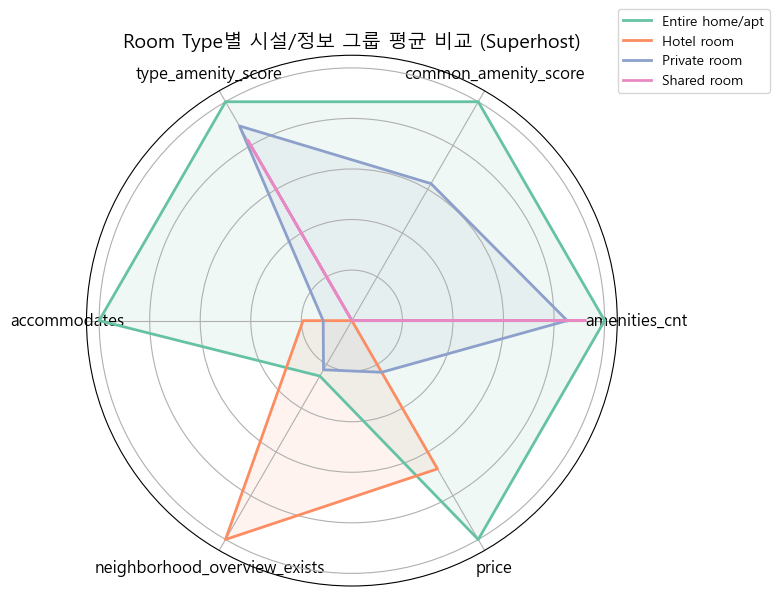

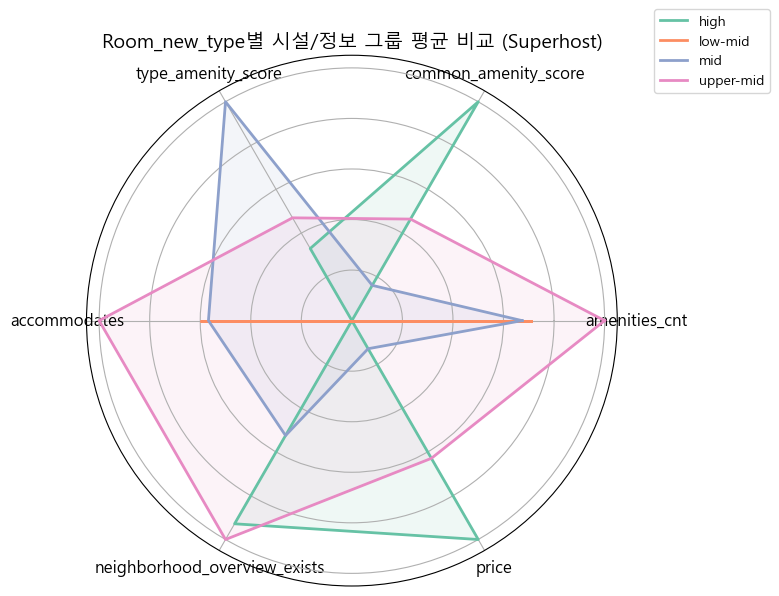

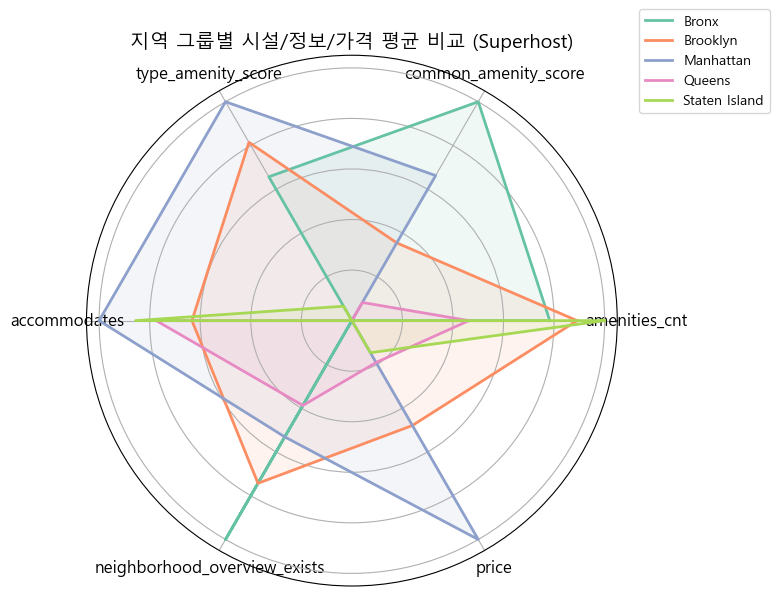

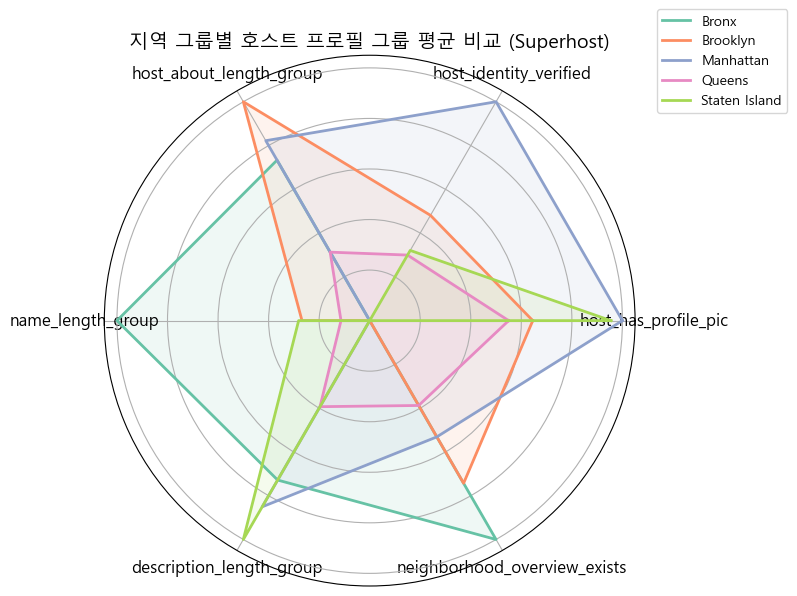

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.font_manager as fm
import platform

# 슈퍼호스트만 필터링
df_super = df[df['host_is_superhost'] == 1].copy()

# 범주형 변수 숫자 인코딩
cat_cols = ['host_about_length_group', 'name_length_group', 'description_length_group']
for col in cat_cols:
    if df_super[col].dtype == 'object':
        le = LabelEncoder()
        df_super[col] = le.fit_transform(df_super[col].astype(str))

def plot_radar_chart(df, group_col, value_cols, title):
    group_means = df.groupby(group_col)[value_cols].mean()
    group_means_norm = (group_means - group_means.min()) / (group_means.max() - group_means.min())
    
    labels = value_cols
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    colors = plt.cm.Set2.colors
    
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    
    for i, (idx, row) in enumerate(group_means_norm.iterrows()):
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=idx, color=colors[i % len(colors)], linewidth=2)
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])
    ax.set_title(title, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# ① 시설/정보 그룹

facility_info_cols = ['amenities_cnt', 'common_amenity_score', 'type_amenity_score', 'accommodates', 'neighborhood_overview_exists', 'price']
plot_radar_chart(df_super, 'room_type', facility_info_cols, 'Room Type별 시설/정보 그룹 평균 비교 (Superhost)')

facility_info_cols = ['amenities_cnt', 'common_amenity_score', 'type_amenity_score', 'accommodates', 'neighborhood_overview_exists', 'price']
plot_radar_chart(df_super, 'room_new_type', facility_info_cols, 'Room_new_type별 시설/정보 그룹 평균 비교 (Superhost)')


value_cols = ['amenities_cnt','common_amenity_score','type_amenity_score','accommodates','neighborhood_overview_exists','price']
plot_radar_chart(df_super, 'neighbourhood_group_cleansed', value_cols, '지역 그룹별 시설/정보/가격 평균 비교 (Superhost)')


host_profile_cols = ['host_has_profile_pic', 'host_identity_verified', 'host_about_length_group', 'name_length_group', 'description_length_group','neighborhood_overview_exists']
plot_radar_chart(df_super, 'neighbourhood_group_cleansed', host_profile_cols, '지역 그룹별 호스트 프로필 그룹 평균 비교 (Superhost)')

In [ ]:
# host_response_time → 점수 변환 함수
def response_time_to_score(response_time_str):
    mapping = {
        'within an hour': 4,
        'within a few hours': 3,
        'within a day': 2,
        'a few days or more': 1
    }
    return mapping.get(response_time_str.lower(), 0)  # 기본 0점

# host_response_rate(0~100) → 점수 변환 함수
def response_rate_to_score(rate_percent):
    rate = rate_percent / 100
    if rate <= 0.25:
        return 1
    elif rate <= 0.5:
        return 2
    elif rate <= 0.75:
        return 3
    else:
        return 4

# host_acceptance_rate(0~100) → 점수 변환 함수
def acceptance_rate_to_score(rate_percent):
    rate = rate_percent / 100
    if rate <= 0.25:
        return 1
    elif rate <= 0.5:
        return 2
    elif rate <= 0.75:
        return 3
    else:
        return 4

# name_length → 그룹 변환 함수 (예: 'short_or_med', 'long', 'empty')
def length_to_group(length, median_or_avg, zero_group='empty', long_group='long', other_group='short_or_med'):
    if length == 0:
        return zero_group
    elif length > median_or_avg:
        return long_group
    else:
        return other_group

# amenities 점수 계산 함수 (참고용, 실제 입력시 amenities 리스트 필요)
common_amenities = ['Carbon monoxide alarm', 'Essentials', 'Hangers', 'Smoke alarm', 'Wifi']

type_amenity_dict = {
    'high': ['Air conditioning', 'Building staff', 'Elevator', 'Gym', 'Heating', 'Paid parking off premises', 'Shampoo'],
    'low-mid': ['Cleaning products', 'Dining table', 'Exterior security cameras on property', 'Free street parking', 
                'Freezer', 'Laundromat nearby', 'Lock on bedroom door', 'Microwave'],
    'mid': ['Cooking basics', 'Kitchen', 'Oven'],
    'upper-mid': ['Bathtub', 'Cleaning products', 'Cooking basics', 'Dishes and silverware', 'Elevator', 'Freezer']
}

def calc_amenity_scores(amenities_list, room_new_type):
    # common amenity 점수
    common_match = sum(1 for a in amenities_list if a in common_amenities) / len(common_amenities) if common_amenities else 0

    # 타입별 amenity 점수
    type_amenities = type_amenity_dict.get(room_new_type, [])
    type_match = sum(1 for a in amenities_list if a in type_amenities) / len(type_amenities) if type_amenities else 0

    return round(common_match, 3), round(type_match, 3)

In [ ]:
# 예시 입력값
user_input = {
    'host_response_time': 'within an hour',
    'host_response_rate': 85,  # %
    'host_acceptance_rate': 78,  # %
    'name_length': 15,
    'name_length_avg': 10,  # 예시, 실제 평균값 넣기
    'amenities': ['Wifi', 'Essentials', 'Hangers', 'Oven', 'Kitchen'],
    'room_new_type': 'mid'
}

# 점수 계산
response_time_score = response_time_to_score(user_input['host_response_time'])
response_rate_score = response_rate_to_score(user_input['host_response_rate'])
acceptance_rate_score = acceptance_rate_to_score(user_input['host_acceptance_rate'])
name_length_group = length_to_group(user_input['name_length'], user_input['name_length_avg'])
common_amenity_score, type_amenity_score = calc_amenity_scores(user_input['amenities'], user_input['room_new_type'])

print(f"host_response_time_score: {response_time_score}")
print(f"host_response_rate_score: {response_rate_score}")
print(f"host_acceptance_rate_score: {acceptance_rate_score}")
print(f"name_length_group: {name_length_group}")
print(f"common_amenity_score: {common_amenity_score}")
print(f"type_amenity_score: {type_amenity_score}")

host_response_time_score: 4
host_response_rate_score: 4
host_acceptance_rate_score: 4
name_length_group: long
common_amenity_score: 0.6
type_amenity_score: 0.667
